<a href="https://colab.research.google.com/github/jaydent22/ics661-assignments/blob/main/hw3/661_HW3_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT for sentiment analysis

This notebook involves using the pretrained BERT model to classify movie reviews as positive or negative.

## Setup

In [1]:
!pip install transformers
!pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification, create_optimizer, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import tensorflow as tf

In [3]:
for gpu in tf.config.experimental.list_physical_devices('GPU'):
  tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Preprocessing

In [5]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [6]:
for index, row in train_df.iterrows():
  if row['sentiment'] == 'pos':
    train_df.at[index, 'sentiment'] = 1
  else:
    train_df.at[index, 'sentiment'] = 0
for index, row in test_df.iterrows():
  if row['sentiment'] == 'pos':
    test_df.at[index, 'sentiment'] = 1
  else:
    test_df.at[index, 'sentiment'] = 0

In [7]:
print(train_df.sentiment.value_counts())

sentiment
1    12500
0    12500
Name: count, dtype: int64


In [8]:
print(test_df.sentiment.value_counts())

sentiment
1    12500
0    12500
Name: count, dtype: int64


In [9]:
# train_df = train_df.apply(lambda row: InputExample(guid=None, text_a=row.review, label=row.sentiment), axis=1)
# test_df = test_df.apply(lambda row: InputExample(guid=None, text_a=row.review, label=row.sentiment), axis=1)

In [10]:
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [11]:
train_df.head(5)

,review,sentiment
0,Great little thriller. I was expecting some ty...,1
1,"Nothing could have saved this movie, not even ...",0
2,This was a good movie. It wasn't your typical ...,1
3,From the pen of Richard Condon (The Manchurian...,0
4,I suppose that today this film has relevance b...,0


In [12]:
train_df.iloc[0]

,0
review,Great little thriller. I was expecting some ty...
sentiment,1


In [13]:
print(list(train_df))

['review', 'sentiment']


In [14]:
def tokenize_data(data, tokenizer, max_length=128):
  return tokenizer(
      data.tolist(),
      max_length=max_length,
      padding='max_length',
      truncation=True,
      return_tensors='tf'
  )

In [15]:
train_encodings = tokenize_data(train_df.review, tokenizer, max_length=256)
test_encodings = tokenize_data(test_df.review, tokenizer, max_length=256)

In [16]:
print(len(train_encodings['input_ids']))
print(len(train_encodings['attention_mask']))
print(len(test_encodings['input_ids']))
print(len(test_encodings['attention_mask']))

25000
25000
25000
25000


In [17]:
train_labels = tf.convert_to_tensor(train_df.sentiment.values.astype('float32'))
test_labels = tf.convert_to_tensor(test_df.sentiment.values.astype('float32'))

In [18]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
a
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels))
# test_dataset = test_dataset.shuffle(len(test_df))
val_dataset = test_dataset.take(12500)
test_dataset = test_dataset.skip(12500)

val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [19]:
print(len(train_dataset))
for i in train_dataset.take(1):
  print(type(i))
  print(i[0].keys())
  print(i[0]['input_ids'].shape)
  print(i[0]['attention_mask'].shape)
  print(i[1])

782
<class 'tuple'>
dict_keys(['input_ids', 'attention_mask'])
(32, 256)
(32, 256)
tf.Tensor(
[1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 0. 1. 0. 0.], shape=(32,), dtype=float32)


In [20]:
print(len(val_dataset))
for i in val_dataset.take(1):
  print(type(i))
  print(i[0].keys())
  print(i[0]['input_ids'].shape)
  print(i[0]['attention_mask'].shape)
  print(i[1])

391
<class 'tuple'>
dict_keys(['input_ids', 'attention_mask'])
(32, 256)
(32, 256)
tf.Tensor(
[1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 0. 1. 0. 0.], shape=(32,), dtype=float32)


In [21]:
print(len(test_dataset))
for i in test_dataset.take(1):
  print(type(i))
  print(i[0].keys())
  print(i[0]['input_ids'].shape)
  print(i[0]['attention_mask'].shape)
  print(i[1])

391
<class 'tuple'>
dict_keys(['input_ids', 'attention_mask'])
(32, 256)
(32, 256)
tf.Tensor(
[1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1.
 0. 1. 1. 1. 0. 1. 0. 1.], shape=(32,), dtype=float32)


## BERT Model

In [35]:
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [36]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
 dropout_59 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66954241 (255.41 MB)
Trainable params: 66954241 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training

In [37]:
optimizer, schedule = create_optimizer(init_lr=1e-5, num_warmup_steps=0, num_train_steps=len(train_dataset) * 5)

In [38]:
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_dataset, epochs=5, validation_data=val_dataset)

Epoch 1/5
782/782 [==============================] - 115s 126ms/step - loss: 0.3114 - accuracy: 0.8592 - val_loss: 0.2390 - val_accuracy: 0.8990
Epoch 2/5
782/782 [==============================] - 87s 111ms/step - loss: 0.2025 - accuracy: 0.9210 - val_loss: 0.2464 - val_accuracy: 0.9113
Epoch 3/5
782/782 [==============================] - 87s 111ms/step - loss: 0.1513 - accuracy: 0.9462 - val_loss: 0.2573 - val_accuracy: 0.9106
Epoch 4/5
782/782 [==============================] - 87s 111ms/step - loss: 0.1192 - accuracy: 0.9596 - val_loss: 0.2819 - val_accuracy: 0.9048
Epoch 5/5
782/782 [==============================] - 87s 111ms/step - loss: 0.0937 - accuracy: 0.9704 - val_loss: 0.2732 - val_accuracy: 0.9095


Text(0.5, 0, 'epoch')

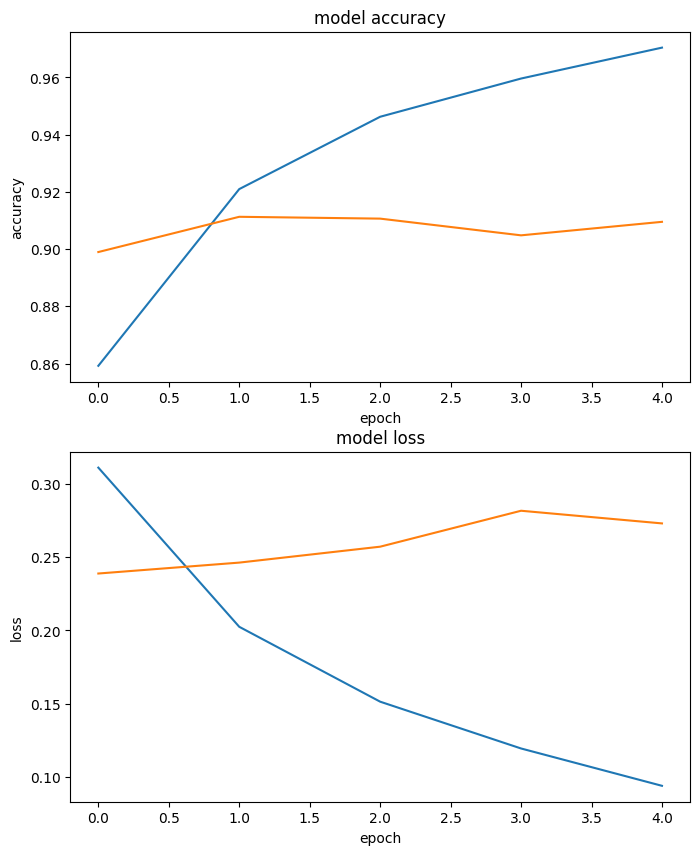

In [39]:
%matplotlib inline

fig, ax = plt.subplots(2, figsize=(8,10))
ax[0].plot(history.history['accuracy'], label='acc')
ax[0].plot(history.history['val_accuracy'], label='val acc')
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[1].plot(history.history['loss'], label='loss')
ax[1].plot(history.history['val_loss'], label='val loss')
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
plt.legend()

## Evaluation

In [40]:
acc = model.evaluate(test_dataset)
print("Accuracy: ", acc[1])

391/391 [==============================] - 14s 35ms/step - loss: 0.2676 - accuracy: 0.9119
Accuracy:  0.9119200110435486


In [41]:
y_true = []
for batch in test_dataset:
  y_true.extend(batch[1].numpy())

In [42]:
print(len(y_true))

12500


In [43]:
pred_soft = model.predict(test_dataset)
print(pred_soft)

391/391 [==============================] - 15s 34ms/step
TFSequenceClassifierOutput(loss=None, logits=array([[ 4.819585 ],
       [ 5.4901237],
       [ 5.1712956],
       ...,
       [ 0.8257246],
       [-1.7541285],
       [-4.891809 ]], dtype=float32), hidden_states=None, attentions=None)


In [44]:
print(len(pred_soft[0]))

12500


In [45]:
pred = tf.nn.sigmoid(pred_soft[0]).numpy()
pred = np.round(pred)
print(classification_report(y_true, pred))

              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91      6308
         1.0       0.91      0.92      0.91      6192

    accuracy                           0.91     12500
   macro avg       0.91      0.91      0.91     12500
weighted avg       0.91      0.91      0.91     12500



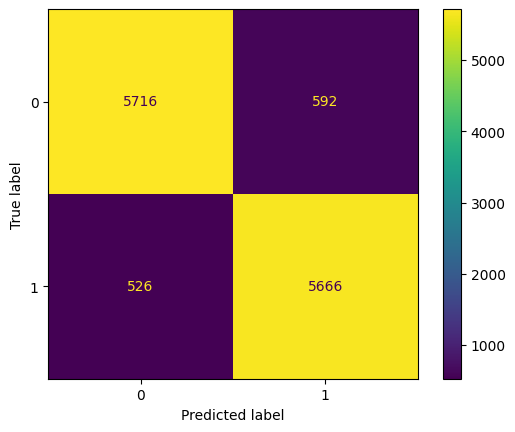

In [46]:
cm = confusion_matrix(y_true, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [47]:
print("Overall metrics:\n")
print("Accuracy: %.2f" % (acc[1]))
print("Precision: %.2f" % (precision_score(y_true, pred)))
print("Recall: %.2f" % (recall_score(y_true, pred)))
print("F1 score: %.2f" % (f1_score(y_true, pred)))

Overall metrics:

Accuracy: 0.91
Precision: 0.91
Recall: 0.92
F1 score: 0.91


## Ablation Study

Testing model with higher learning rate

In [53]:
ablated = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [54]:
optimizer, schedule = create_optimizer(init_lr=5e-4, num_warmup_steps=0, num_train_steps=len(train_dataset) * 5)

In [55]:
ablated.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
ab_history = ablated.fit(train_dataset, epochs=5, validation_data=val_dataset)

Epoch 1/5
782/782 [==============================] - 115s 126ms/step - loss: 0.6953 - accuracy: 0.5001 - val_loss: 0.6931 - val_accuracy: 0.4954
Epoch 2/5
782/782 [==============================] - 87s 111ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4954
Epoch 3/5
782/782 [==============================] - 87s 111ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4954
Epoch 4/5
782/782 [==============================] - 87s 111ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4954
Epoch 5/5
782/782 [==============================] - 87s 111ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4954


Text(0.5, 0, 'epoch')

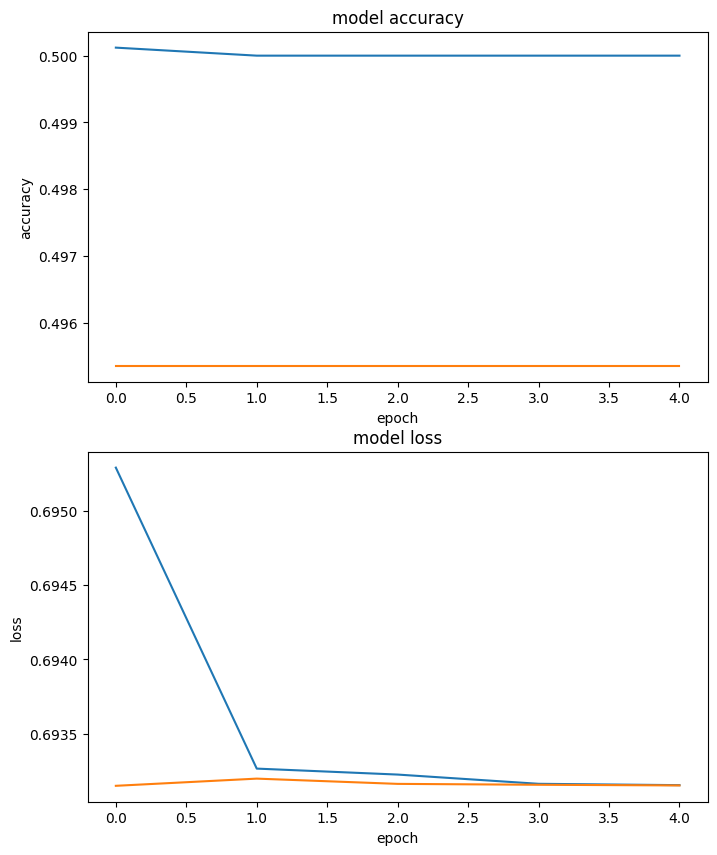

In [56]:
%matplotlib inline

fig, ax = plt.subplots(2, figsize=(8,10))
ax[0].plot(ab_history.history['accuracy'])
ax[0].plot(ab_history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[1].plot(ab_history.history['loss'])
ax[1].plot(ab_history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')

In [57]:
ab_pred_soft = ablated.predict(test_dataset)
ab_pred = tf.nn.sigmoid(ab_pred_soft[0]).numpy()
ab_pred = np.round(ab_pred)
print(classification_report(y_true, ab_pred))

391/391 [==============================] - 15s 34ms/step
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67      6308
         1.0       0.00      0.00      0.00      6192

    accuracy                           0.50     12500
   macro avg       0.25      0.50      0.34     12500
weighted avg       0.25      0.50      0.34     12500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


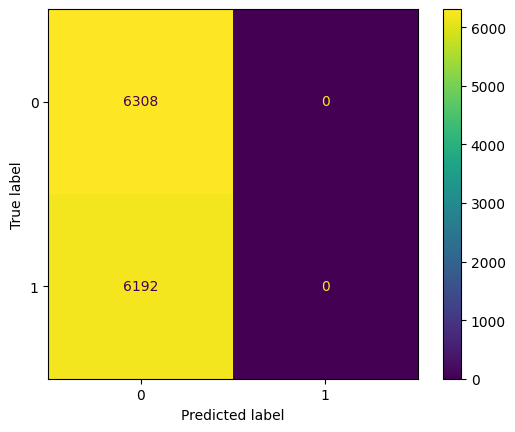

In [58]:
cm = confusion_matrix(y_true, ab_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [59]:
print("Overall metrics:\n")
print("Accuracy: %.2f" % (accuracy_score(y_true, ab_pred)))
print("Precision: %.2f" % (precision_score(y_true, ab_pred)))
print("Recall: %.2f" % (recall_score(y_true, ab_pred)))
print("F1 score: %.2f" % (f1_score(y_true, ab_pred)))

Overall metrics:

Accuracy: 0.50
Precision: 0.00
Recall: 0.00
F1 score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
